# Tabular Playground - Kaggle Apr 2022
oh just another feeble attempt at this w 15 days remaining even though seq cant get the ecuador store sales right T_T

at the time of this commit, ive never made a full run, dummy or real.
theoretically it would take about 7-8 hours just to do a dummy run, and a real run may take 10 hours.

will update commit sometime in the future

TODO LIST:
-..

### Importing Modules

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa as tsa
import sklearn as skl
# import pycaret # remember to use venv "env1" for pycaret (still didnt work)
import warnings

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble, linear_model, neighbors, svm, tree
from sklearn import metrics

plt.style.use('dark_background')
warnings.filterwarnings('ignore')

### Importing Data

In [54]:
df = pd.read_csv('train.csv')
df_states = pd.read_csv('train_labels.csv')
df = df.merge(df_states, on='sequence')

sensors = [ col for col in df.columns if col[:6] == "sensor" ]

### Initial EDA

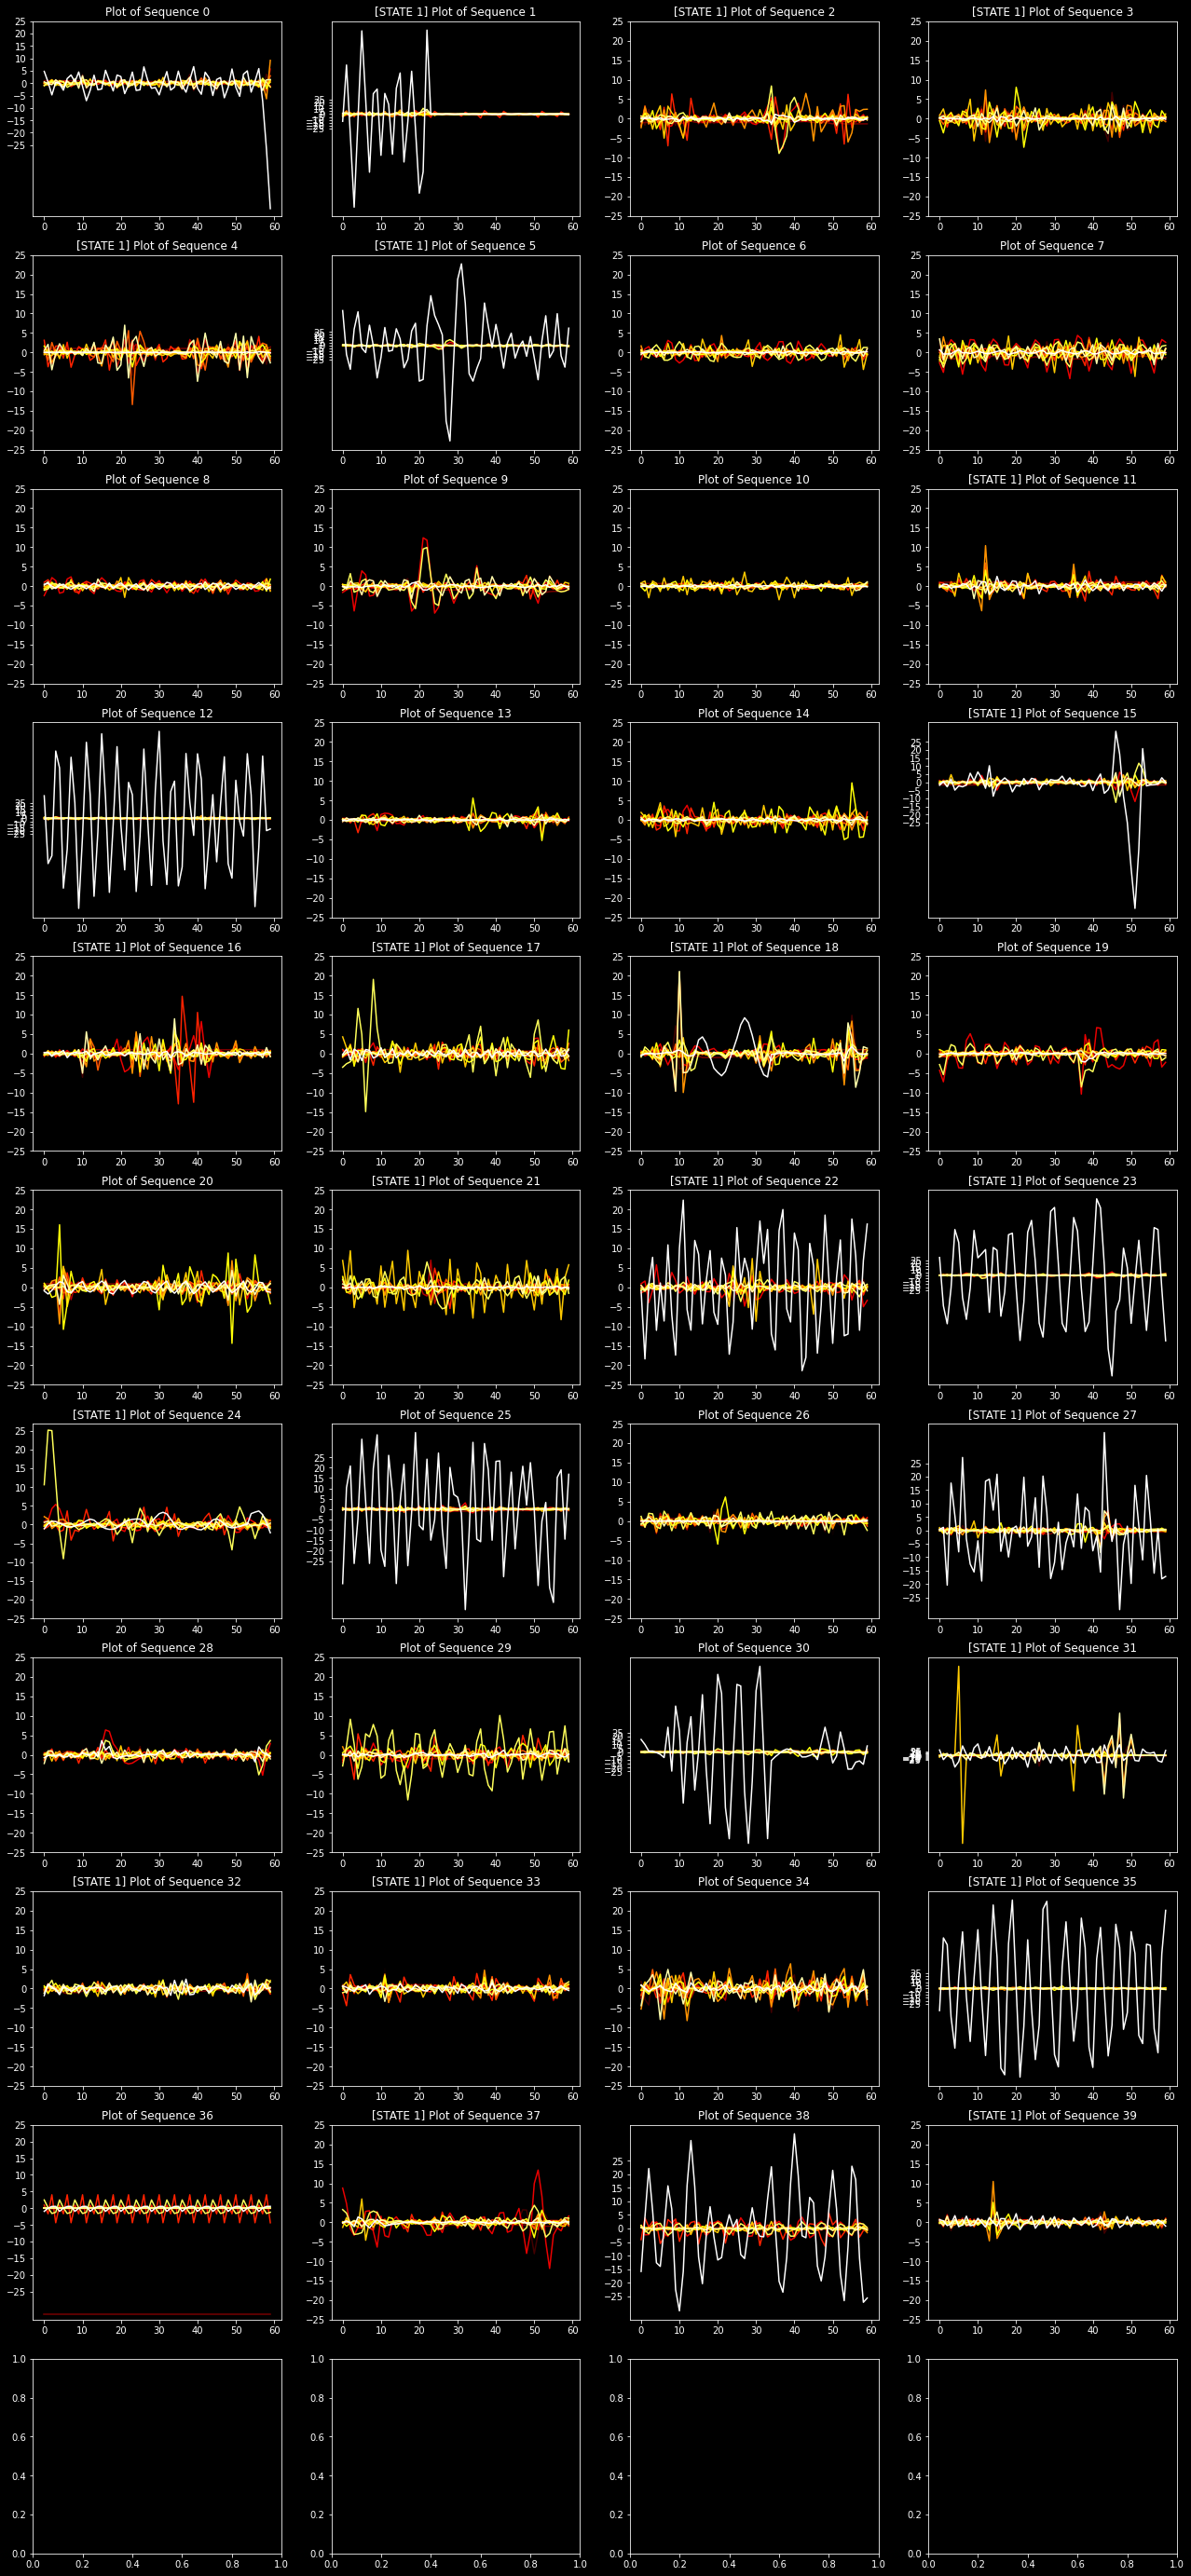

In [55]:
n = 40
ytick_bounds = 25
# ^ Customizable params

fig, ax = plt.subplots(n//4 + 1, 4)

# Colourmaps for graph (to differentiate different sensors)
a = plt.cm.hot(np.linspace(0, 1, 13))
b = plt.cm.hot(np.linspace(0, 1, 13))

a_arr, b_arr = np.empty(50), np.empty(50)
seq, i, j, k = 0, 0, 0, 0
for seq in range(n): # Iterates through each sequence from 0 to n-1
    
    seqframe = df.loc[df['sequence'] == seq]
    state = df.loc[seqframe.first_valid_index(), 'state']
    i = seq//4
    j = seq % 4
    
    for k in range(13): # Iterates through each sensor in the sequence
        sens_num = f"0{k}" if (k < 10) else f"{k}"
        if (state == 1):
            ax[i, j].plot(seqframe['step'], seqframe[f'sensor_{sens_num}'], color=a[k])
            ax[i, j].set_title(f"[STATE 1] Plot of Sequence {seq}")
        else:
            ax[i, j].plot(seqframe['step'], seqframe[f'sensor_{sens_num}'], color=b[k])
            ax[i, j].set_title(f"Plot of Sequence {seq}")
        ax[i, j].set_yticks(np.arange(-ytick_bounds, ytick_bounds+1,ytick_bounds/5))
            
fig.set_figwidth(22)
fig.set_figheight(5/4 * n)
fig.show()

In [56]:
file = open("sensor_data.txt", 'w')

# print(np.mean(a_arr), np.mean(b_arr))
for k in range(0,13):
    sens_num = f"0{k}" if (k < 10) else f"{k}"
    state_groups = df[f'sensor_{sens_num}'].groupby(df_states['state'])
    print(f"\n------------ Sensor {sens_num} ------------", file=file)
    print(state_groups.describe(), file=file)
    
file.close()

From sensor_data, we can conclude that there really isn't much we can gather from the 'big picture' of sensors' statistics (mean, var, etc.)
With one exception: The standard deviation of sensor 8 seems really low on STATE 0 sequences.

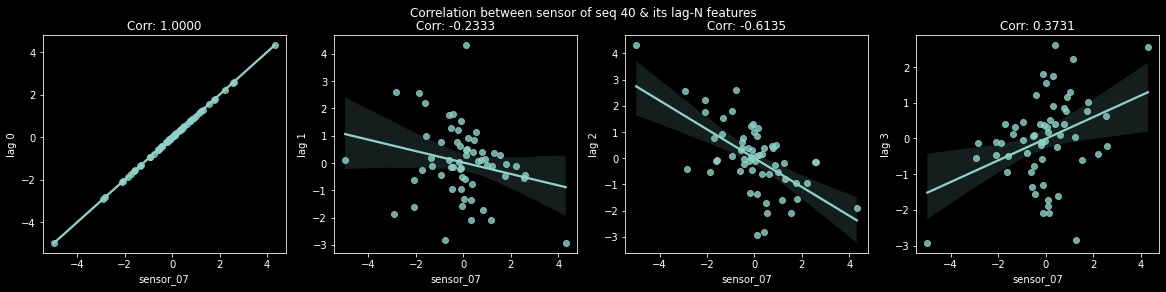

In [57]:
P = 40
N = 4
SENSOR_NAME = 'sensor_07'

for p in range(P,P+1): # Iterates through 0 to P sequences; (change the range to print all)
    i = 0
    fig, ax = plt.subplots(1, 4)
    this_seq = df.loc[df['sequence'] == p].loc[:,['step', SENSOR_NAME]]

    for i in range(N): # Iterates through each lag in range to N
        this_seq[f'lag_{i}'] = this_seq[SENSOR_NAME].shift(i)
        this_seq[f'lag_{i}'].bfill(inplace=True)
        this_seq[f'lag_{i}'].ffill(inplace=True)

        sns.regplot(this_seq[SENSOR_NAME], this_seq[f'lag_{i}'], ax=ax[i])
        corr = np.corrcoef(this_seq[SENSOR_NAME], this_seq[f'lag_{i}'])[0][1]
        ax[i].title.set_text(f"Corr: {corr:.4f}")
        ax[i].set_ylabel(f"lag {i}")

    fig.suptitle(f"Correlation between sensor of seq {p} & its lag-N features")
    fig.set_figwidth(20)
    fig.show()

From the above graph, we can conclude that there is usually a -0.2 to -0.6 weak negative correlation between a sensor's readings and its lag (previous) features of n=1. Nothing of value of n>1 though.

This does somewhat explain the constant up and down nature of the sensor readings, but nothing else really.

In [58]:
this_seq['diff_1'] = this_seq[SENSOR_NAME] - this_seq['lag_1']
this_seq['diff_2'] = this_seq['lag_1'] - this_seq['lag_2']

In [59]:
# correlation between sensors
# with plt.imshow() or sns.heatmap()

### Data Preprocessing & Feature Engineering

This will momentarily SKIP the feature engineering section.

In [60]:
DUMMY_RUN = False

In [61]:
def get_seqframe(i):
    ''' Return a DataFrame representing the full 60-second time readings of all sensors 
    for sequence i.
    
    Returned as flattened 1-row DataFrame.'''
    return pd.DataFrame(df.loc[df['sequence'] == i].to_numpy().flatten().reshape(1,-1))

def flatten_step(X):
    ''' Returned a fully-flattened DataFrame of X, pivoting off the sequence column.
    With n number of sequences, a DataFrame will be returned with shape of (n, 60 * num of sensors + something..)
    
    Intuitively: Returns a joint/merger of get_seqframe(i) for all i in X.'''
    
    RANGE = len(X['sequence'])
    
    X_new = pd.DataFrame(X['sequence'].unique()).rename(columns={0: 'sequence'})
    X_new.set_index('sequence')

    sequence = get_seqframe(0)
    sequence.index = [0]
    X_new = X_new.merge(sequence, how='left', left_index=True, right_index=True)

    for i in (range(1,RANGE)):
        sequence = get_seqframe(i)
        sequence.index = [i]
        X_new.update(sequence, overwrite=False)
    return X_new    
    
df_flat = flatten_step(df.iloc[:60*500,:])
X = df_flat.drop(columns=[1019])

In [62]:
X.set_index('sequence')

# Set y 
y = df_states.iloc[X.index, :]
y.set_index('sequence', inplace=True)

# Split X & y into train & test set for dummy/train run
if DUMMY_RUN:
    X_train, X_test, y_train, y_test \
    = model_selection.train_test_split(X, y, train_size=0.7, random_state=42)
else:
    X_train = X
    y_train = y
    
    X_test_raw = pd.read_csv('test.csv')
    X_test = flatten_step(X_test_raw.iloc[:,:])

In [63]:
print(X_train.shape, X_test.shape)

(500, 1020) (12218, 1021)


### Forecast

In [64]:
classifiers = {
    'RandomForest': skl.ensemble.RandomForestClassifier(),
    'AdaBoost': ensemble.AdaBoostClassifier(),
    'LogisticRegression': skl.linear_model.LogisticRegression(),
    'ExtraTrees': ensemble.ExtraTreesClassifier(),
    'KNN': neighbors.KNeighborsClassifier(),
    'SVC': svm.SVC()
}
scores = dict()


if DUMMY_RUN:
    for name in classifiers:
        c = classifiers[name]
        
        c.fit(X_train, y_train)
        y_pred = c.predict(X_test)
        scores[name] = metrics.accuracy_score(y_pred,y_test)
else:
    choice = 'RandomForest'
    
    X_test.drop(columns=[1019])
    c = classifiers[choice]
    c.fit(X_train, y_train)
    y_pred = c.predict(X_test)

ValueError: X has 1021 features, but RandomForestClassifier is expecting 1020 features as input.

### Metrics / Export

In [ ]:
if DUMMY_RUN:
    print(scores)
else:
    output = pd.DataFrame({'sequence': X_test['sequence'].values, 'state': y_pred})
    output.to_csv('pred.csv', index=False)

{'RandomForest': 1.0, 'AdaBoost': 1.0, 'LogisticRegression': 0.7333333333333333, 'ExtraTrees': 1.0, 'KNN': 0.5333333333333333, 'SVC': 0.4666666666666667}
